# Ground-truth performance and gradient norms

This notebook inspects the initialization schemes for LQGs and time-varying linear policies described in section 5.1 of the [paper](https://www.overleaf.com/read/cmbgmxxpxqzr).

### Checklist

- [x] Fix `n_state`, `n_ctrl`, `horizon`
- [x] Sample random LQGs
- [x] Sample random policies
- [x] Evaluate the expected return
- [x] Evaluate the value gradient norm
- [ ] Search numpy, scipy for methods for visualizing the distributions

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics 
    $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs 
    $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} - \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state 
    $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

### Imports

In [1]:
%matplotlib inline
import warnings
from __future__ import annotations
from typing import Callable
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import lqsvg.torch.named as nt
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import make_lqg
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch import Tensor
from tqdm.notebook import tqdm

sns.set()

---
## Task selection protocol

$$
    \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \mathbf{\mu}_\rho = \mathbf{0}, \quad \mathbf{\Sigma}_{\rho} = \mathbf{I} \\
    \mathcal{M} = \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \cup \{ \mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho \}
$$

In [2]:
def sample_lqg(n_state: int, n_ctrl: int, horizon: int, n_batch: Optional[int] = None) -> tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]:
    dynamics, cost = make_lqg(
        state_size=n_state,
        ctrl_size=n_ctrl,
        horizon=horizon,
        stationary=False,
        n_batch=n_batch,
        np_random=None,
    )

    mat_shape = (n_state, n_state)
    vec_shape = (n_state,)
    mat_names = ("B " if n_batch else "") + "R C"
    vec_names = ("B " if n_batch else "") + "R"
    batch_shape = (n_batch,) if n_batch else ()

    init = lqr.GaussInit(
        mu=torch.zeros(*(batch_shape + vec_shape)).refine_names(*vec_names.split()),
        sig=torch.eye(n_state).expand(*(batch_shape + mat_shape)).refine_names(*mat_names.split())
    )
    return dynamics, cost, init

In [3]:
def print_lqg(dynamics, cost, init):
    print(f"""
        dynamics:
            F: {dynamics.F.shape}; {dynamics.F.names}
            f: {dynamics.f.shape}; {dynamics.f.names}
            Sig: {dynamics.W.shape}; {dynamics.W.names}
        cost:
            C: {cost.C.shape}; {cost.C.names}            
            c: {cost.c.shape}; {cost.c.names}
        init:
            mu: {init.mu.shape}; {init.mu.names}            
            sig: {init.sig.shape}; {init.sig.names}
    """)

def test_sample_lqg(n_batch=None):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Named tensors.*", module="torch")
        dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=n_batch)
    assert isinstance(dynamics, lqr.LinSDynamics)
    assert isinstance(cost, lqr.QuadCost)
    assert isinstance(init, lqr.GaussInit)
    print_lqg(dynamics, cost, init)

def test_batch_lqgs():
    test_sample_lqg(n_batch=10)

In [4]:
test_sample_lqg()


        dynamics:
            F: torch.Size([100, 2, 4]); ('H', 'R', 'C')
            f: torch.Size([100, 2]); ('H', 'R')
            Sig: torch.Size([100, 2, 2]); ('H', 'R', 'C')
        cost:
            C: torch.Size([100, 4, 4]); ('H', 'R', 'C')            
            c: torch.Size([100, 4]); ('H', 'R')
        init:
            mu: torch.Size([2]); ('R',)            
            sig: torch.Size([2, 2]); ('R', 'C')
    


In [5]:
test_batch_lqgs()


        dynamics:
            F: torch.Size([100, 10, 2, 4]); ('H', 'B', 'R', 'C')
            f: torch.Size([100, 10, 2]); ('H', 'B', 'R')
            Sig: torch.Size([100, 10, 2, 2]); ('H', 'B', 'R', 'C')
        cost:
            C: torch.Size([100, 10, 4, 4]); ('H', 'B', 'R', 'C')            
            c: torch.Size([100, 10, 4]); ('H', 'B', 'R')
        init:
            mu: torch.Size([10, 2]); ('B', 'R')            
            sig: torch.Size([10, 2, 2]); ('B', 'R', 'C')
    


---
## Policy selection protocol

$$
    \mu_\theta(\mathbf{s}) = \mathbf{a} \\
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}} \sim \text{PiDist}(\mathcal{M})
$$

In [6]:
def dims_from_dynamics(dynamics: lqr.LinSDynamics) -> tuple[int, int, int]:
    n_state = dynamics.F.size("R")
    n_ctrl = dynamics.F.size("C") - n_state
    horizon = dynamics.F.size("H")
    return n_state, n_ctrl, horizon

In [7]:
def solution(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> tuple[lqr.Linear, lqr.Quadratic, lqr.Quadratic]:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    solver = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    pistar, qstar, vstar = solver(dynamics, cost)
    return pistar, qstar, vstar

In [8]:
def optimal_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    pistar, _, _ = solution(dynamics, cost)
    return pistar

In [9]:
def perturb_policy(dims: tuple[int, int, int], policy: lqr.Linear) -> lqr.Linear:
    n_state, n_ctrl, _ = dims
    K, k = (
        g + 0.5 * torch.randn_like(g) / (n_state + np.sqrt(n_ctrl)) 
        for g in policy
    )
#     scale = 1 / (n_state + np.sqrt(n_ctrl))
#     K, k = (g + 2 * torch.rand_like(g) * scale - scale for g in policy)
    return (K, k)

def sample_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    dims = dims_from_dynamics(dynamics)
    pistar = optimal_policy(dynamics, cost)
    random = perturb_policy(dims, pistar)
    return random

In [10]:
def print_policy(policy: lqr.Linear):
    K, k = policy
    print(f"""
        K: {K.shape}; {K.names}
        k: {k.shape}; {k.names}
    """)
    
def test_optimal_policy():
    dynamics, cost, _ = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    print_policy(optimal_policy(dynamics, cost))

def test_sample_policy():
    dynamics, cost, _ = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    print_policy(sample_policy(dynamics, cost))

In [11]:
test_optimal_policy()


        K: torch.Size([100, 10, 2, 2]); ('H', None, 'R', 'C')
        k: torch.Size([100, 10, 2]); ('H', None, 'R')
    


In [12]:
test_sample_policy()


        K: torch.Size([100, 10, 2, 2]); ('H', None, 'R', 'C')
        k: torch.Size([100, 10, 2]); ('H', None, 'R')
    


In [13]:
def policy_distance(policy_a: lqr.Linear, policy_b: lqr.Linear) -> Tensor:
    Ka, ka = policy_a
    Kb, kb = policy_b
    
    K_dist = torch.linalg.norm(nt.unnamed(Ka - Kb), dim=(-2, -1))
    k_dist = torch.linalg.norm(nt.unnamed(ka - kb), dim=-1)
    
    # Reduce by horizon
    total_norm = torch.linalg.norm(torch.cat((K_dist, k_dist), dim=0), dim=0)    
    return total_norm

In [14]:
def test_policy_distance():
    dynamics, cost, _ = sample_lqg(n_state=10, n_ctrl=10, horizon=100, n_batch=100)
    optimal = optimal_policy(dynamics, cost)
    random = perturb_policy(dims_from_dynamics(dynamics), optimal)
    distance = policy_distance(optimal, random)
    print(f"""\
    Policy distances: {distance}, {distance.shape}\
    """)

In [15]:
test_policy_distance()

    Policy distances: tensor([3.9930, 3.9566, 3.9818, 3.9760, 4.0164, 3.9910, 4.0212, 4.0160, 3.9702,
        3.9987, 3.9612, 4.0016, 3.9926, 3.9743, 3.9706, 3.9362, 3.9937, 3.9628,
        4.0015, 3.9345, 3.9548, 3.9727, 3.9933, 4.0230, 3.9694, 3.9771, 4.0089,
        3.9552, 3.9493, 3.9377, 3.9654, 3.9933, 3.9825, 3.9529, 3.9744, 3.9949,
        3.9502, 4.0067, 4.0263, 4.0512, 4.0063, 3.9769, 3.9820, 4.0137, 3.9366,
        3.9614, 3.9842, 3.9686, 4.0026, 3.9903, 3.9389, 4.0153, 3.9682, 3.9726,
        3.9716, 3.9743, 3.9924, 3.9551, 3.9886, 3.9875, 4.0210, 4.0002, 3.9322,
        3.9686, 3.9228, 3.9524, 3.9761, 3.9573, 4.0160, 3.9664, 3.9879, 3.9489,
        4.0332, 3.9897, 3.9887, 4.0079, 4.0082, 4.0428, 3.9799, 3.9444, 3.9984,
        4.0167, 4.0270, 3.9641, 4.0177, 3.9826, 3.9977, 3.9635, 4.0062, 3.9918,
        4.0308, 3.9649, 3.9883, 3.9500, 3.9843, 4.0248, 3.9356, 3.9660, 4.0094,
        3.9885]), torch.Size([100])    


---
## Ground-truth policy performance

<center><b>Sampling</b></center>
$$
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}} \sim \text{PiDist}(\mathcal{M})
$$
<br>

<center><b>Prediction</b></center>
<!-- LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients: -->
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta) \\
V^\mu(\mathbf{s}, t) = -\tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} - \mathbf{v}_t(\theta)^\intercal \mathbf{s} - v_t(\theta)
$$
<br>

<center><b>Performance</b></center>
<!-- We can then express policy performance as a direct function of policy parameters: -->
$$
\begin{align}
J(\theta) 
    &= -\mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= -\text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) - \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 - \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 - v_0(\theta)
\end{align}
$$

In [16]:
class ExpectedValue(nn.Module):
    def forward(self, init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
        """Expected cost given mean and covariance matrix of the initial state.

        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        V, v, c = vval
        V = nt.matrix(V)
        v = nt.vector_to_matrix(v)
        c = nt.scalar_to_matrix(c)
        mu = nt.vector_to_matrix(init.mu)
        sig = nt.matrix(init.sig)

        value = (
            nt.scalar_to_matrix(nt.trace(sig @ V)) / 2
            + nt.transpose(mu) @ V @ mu
            + nt.transpose(v) @ mu
            + c
        )
        return nt.matrix_to_scalar(value)


class PolicyLoss(nn.Module):
    def __init__(self, n_state: int, n_ctrl: int, horizon: int):
        super().__init__()
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.expected = ExpectedValue()

    def forward(
        self,
        policy: lqr.Linear,
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ) -> Tensor:
        _, vval = self.predict(policy, dynamics, cost)
        vval = tuple(x.select("H", 0) for x in vval)
        cost = self.expected(init, vval)
        return cost

In [17]:
def policy_loss(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> Tensor:
    n_state, n_ctrl, horizon = dims_from_dynamics(dynamics)
    loss_fn = PolicyLoss(n_state, n_ctrl, horizon)
    loss = loss_fn(policy, dynamics, cost, init)
    return loss

In [18]:
def policy_performance(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> Tensor:
    return -policy_loss(policy, dynamics, cost, init)

In [19]:
def test_policy_loss():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    policy = sample_policy(dynamics, cost)
    loss = policy_loss(policy, dynamics, cost, init)
    print(f"""\
    Loss: {loss}, ({loss.dtype}), ({loss.shape}); 
    ExpectedReturn: {-loss}, ({(-loss).dtype}), ({loss.shape})\
    """)

In [20]:
test_policy_loss()

    Loss: tensor([717.5911, 493.7616, 396.1001, 476.3658, 425.1579, 447.0443, 554.3382,
        441.1033, 517.1869, 363.3606], names=('B',)), (torch.float32), (torch.Size([10])); 
    ExpectedReturn: tensor([-717.5911, -493.7616, -396.1001, -476.3658, -425.1579, -447.0443,
        -554.3382, -441.1033, -517.1869, -363.3606], names=('B',)), (torch.float32), (torch.Size([10]))    


---
## Ground-truth value gradient norm

1. **Sampling**$\rightarrow \mathcal{M}, \theta$; 
2. **Prediction**$\rightarrow \left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right)$; 
3. **Performance**$\rightarrow J(\theta)$;
4. **SVG norm**$\rightarrow \| \nabla J(\theta) \|$.

In [21]:
def compute_batched_svg_norm(exp_ret: Tensor, policy: lqr.Linear) -> Tensor:
    for x in policy:
        x.grad = None
    exp_ret.sum().backward()

    K_grad, k_grad = (x.grad.detach() for x in policy)
#     K_norm = torch.linalg.norm(K_grad, dim=("R", "C"))
#     k_norm = torch.linalg.norm(k_grad, dim=("R",))
    K_norm = torch.linalg.norm(K_grad, dim=(-2, -1))
    k_norm = torch.linalg.norm(k_grad, dim=(-1,))
    # Following PyTorch's clip_grad_norm_ implementation
#     total_norm = torch.linalg.norm(torch.cat((K_norm, k_norm), dim="H"), dim="H")
    total_norm = torch.linalg.norm(torch.cat((K_norm, k_norm), dim=0), dim=0)
    return total_norm

In [22]:
def policy_svg_norm(policy: lqr.Linear, dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit) -> tuple[Tensor, Tensor]:
    eret = policy_performance(policy, dynamics, cost, init)
    svg_norm = compute_batched_svg_norm(eret, policy)
    return eret, svg_norm

In [23]:
def test_random_policy_svg():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    policy = tuple(x.requires_grad_(True) for x in sample_policy(dynamics, cost))
    eret, svg_norm = policy_svg_norm(policy, dynamics, cost, init)
    print(f"Expected return: {eret}, ({eret.dtype}, {eret.shape})")
    print(f"SVG norm: {svg_norm} ({svg_norm.dtype}, {svg_norm.shape})")

In [24]:
test_random_policy_svg()

Expected return: tensor([-547.9412, -492.7896, -415.0845, -352.7963, -520.0991, -482.9095,
        -395.4073, -588.0520, -718.9980, -678.7534], grad_fn=<NegBackward>,
       names=('B',)), (torch.float32, torch.Size([10]))
SVG norm: tensor([ 847.6074,  385.3600,  433.8207,  415.8247,  352.3781,  373.6088,
         334.7491, 1144.7378,  877.3772,  649.7506]) (torch.float32, torch.Size([10]))


In [25]:
def test_optimal_policy_svg():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    pistar, _, vstar = solution(dynamics, cost)
    loss_fn = ExpectedValue()
    eret = -loss_fn(init, tuple(x.select("H", 0) for x in vstar))
    print(f"Optimal expected return: {eret} ({eret.dtype})")

    policy = tuple(x.requires_grad_(True) for x in pistar)
    eret = -policy_loss(policy, dynamics, cost, init)
    print(f"Expected return from Prediction algorithm: {eret} ({eret.dtype})")
    svg_norm = compute_batched_svg_norm(eret, policy)
    print(f"Optimal policy SVG norm: {svg_norm} ({svg_norm.dtype}, {svg_norm.shape})")

In [26]:
test_optimal_policy_svg()

Optimal expected return: tensor([-407.7647, -318.2944, -318.7803, -301.5223, -283.9788, -190.3248,
        -271.1185, -266.5269, -276.6358, -259.6365], names=('B',)) (torch.float32)
Expected return from Prediction algorithm: tensor([-407.7647, -318.2944, -318.7803, -301.5223, -283.9788, -190.3248,
        -271.1185, -266.5269, -276.6358, -259.6365], grad_fn=<NegBackward>,
       names=('B',)) (torch.float32)
Optimal policy SVG norm: tensor([2.0056e-04, 2.3945e-04, 2.4237e-04, 2.8040e-04, 2.1160e-04, 8.1514e-05,
        3.0962e-04, 1.6648e-04, 8.9159e-05, 1.2874e-04]) (torch.float32, torch.Size([10]))


---
## Beyond averages

Next, we evaluate the distribution of optimal/random policy performances for certain LQG problem sizes

### Calculating the expected return (performance) & SVG norm for a batch of LQGs

In [27]:
def expected_return(init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
    expected_value = ExpectedValue()
    expected_cost = expected_value(init, tuple(x.select("H", 0) for x in vval))
    return -expected_cost

In [28]:
@torch.no_grad()
def performance_samples(dims: tuple[int, int, int], optimal: bool = False, samples: int = 100, clip_ctrl_dim: bool = False) -> np.ndarray:
    n_state, n_ctrl, horizon = dims
    if clip_ctrl_dim and n_ctrl < n_state:
        return np.full((samples,), fill_value=np.nan)

    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)

    if optimal:
        pistar, qstar, vstar = solution(dynamics, cost)
        eret = expected_return(init, vstar)
    else:
        policy = sample_policy(dynamics, cost)
        eret = policy_performance(policy, dynamics, cost, init)
    
    return eret.numpy()

In [39]:
def svg_norm_samples(dims: tuple[int, int, int], samples: int = 100, clip_ctrl_dim: bool = False) -> np.ndarray:
    n_state, n_ctrl, horizon = dims
    if clip_ctrl_dim and n_ctrl < n_state:
        return np.full((samples,), fill_value=np.nan)

    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)
    policy = tuple(g.requires_grad_(True) for g in sample_policy(dynamics, cost))
    _, svg_norm = policy_svg_norm(policy, dynamics, cost, init)
    return svg_norm.numpy()

### Plotting the performance distribution

In [31]:
def plot_optimal_vs_random_performances_hist(dims: tuple[int, int, int], samples: int = 1000):
    optimal = pd.DataFrame({"performance": performance_samples(dims, optimal=True, samples=samples)})
    random = pd.DataFrame({"performance": performance_samples(dims, optimal=False, samples=samples)})
    
    optimal["optimal"] = True
    random["optimal"] = False
    data = pd.concat([optimal, random])
    
    sns.histplot(data=data, x="performance", hue="optimal", bins=samples // 10)

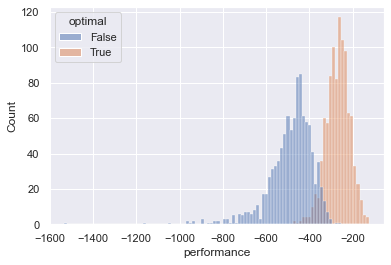

In [32]:
plot_optimal_vs_random_performances_hist((2, 2, 100))

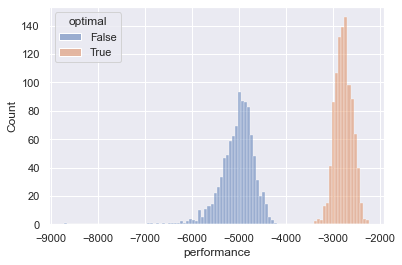

In [33]:
plot_optimal_vs_random_performances_hist((2, 2, 1000))

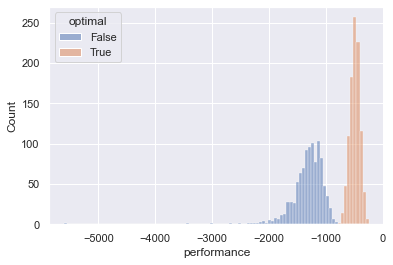

In [34]:
plot_optimal_vs_random_performances_hist((4, 4, 100))

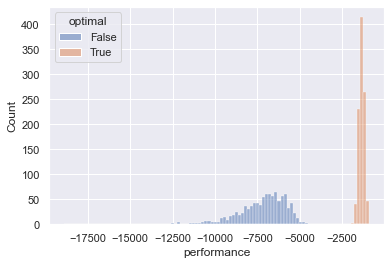

In [35]:
plot_optimal_vs_random_performances_hist((10, 10, 100))

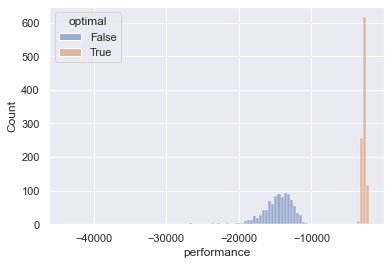

In [36]:
plot_optimal_vs_random_performances_hist((10, 10, 200))

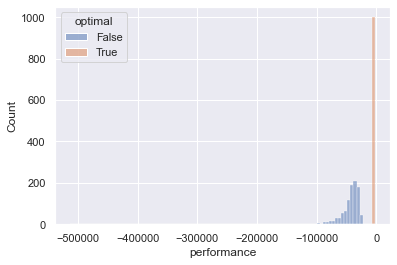

In [46]:
plot_optimal_vs_random_performances_hist((20, 20, 100))

### Plotting the SVG norm distribution

In [37]:
def plot_svg_norm_hist(dims: tuple[int, int, int], samples: int = 1000):
    data = pd.DataFrame({"svg norm": svg_norm_samples(dims, samples=samples)})
    sns.histplot(data=data, x="svg norm", bins=samples // 10)

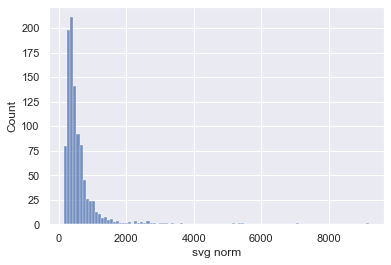

In [40]:
plot_svg_norm_hist((2, 2, 100))

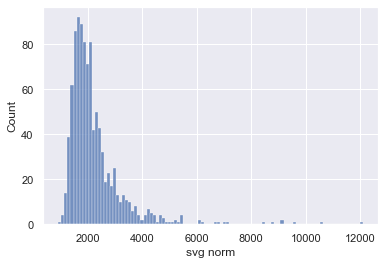

In [41]:
plot_svg_norm_hist((2, 2, 1000))

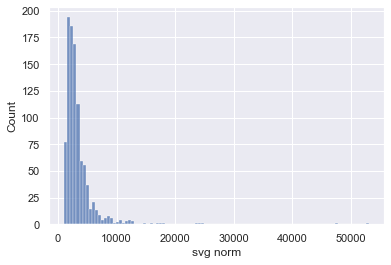

In [42]:
plot_svg_norm_hist((4, 4, 100))

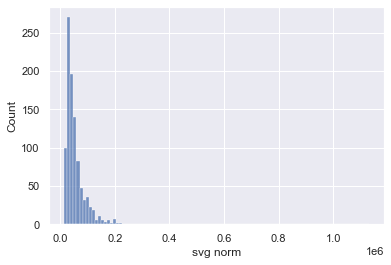

In [43]:
plot_svg_norm_hist((10, 10, 100))

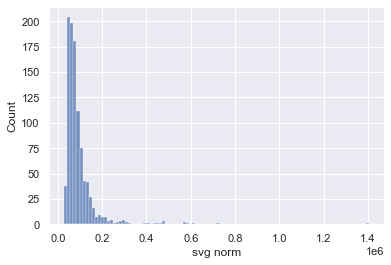

In [44]:
plot_svg_norm_hist((10, 10, 200))

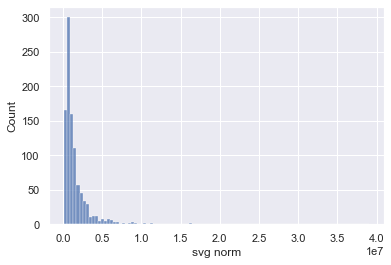

In [45]:
plot_svg_norm_hist((20, 20, 100))

---
## Evaluate cost scaling against each variable

### Checklist
- [x] Stack several LQGs including init dists
- [x] Define range of `n_state`s, `n_ctrl`s, and `horizon`s
- [x] Fix initial values of `n_state=2`, `n_ctrl=2`, `horizon=100`
- [x] Iterate over one of the ranges, e.g., `horizon`s:
  - [x] Generate several LQGs with the current `n_state`, `n_ctrl`, `horizon` and stack them
  - [x] Find the optimal solutions (policies) and evaluate the optimal expected returns
  - [x] Average the results accross the LQGs generated
  - [x] Plot the average against the current `n_state`, `n_ctrl`, `horizon`

In [47]:
def performance_matrix(
    state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon_arr: np.ndarray, perf_sampling_fn: Callable[[int, int, int], np.ndarray], 
) -> np.ndarray:
    pbar = tqdm(
        zip(state_dim_arr, ctrl_dim_arr, horizon_arr), 
        total=len(ctrl_dim_arr), 
        desc="Computing performance by LQG dims"
    )

    exp_ret_arrs = [
        perf_sampling_fn(n_state, n_ctrl, horizon)
        for n_state, n_ctrl, horizon in pbar
    ]

    exp_ret_mat = np.vstack(exp_ret_arrs)
    return exp_ret_mat

#### Optimal expected return vs. state dimension

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

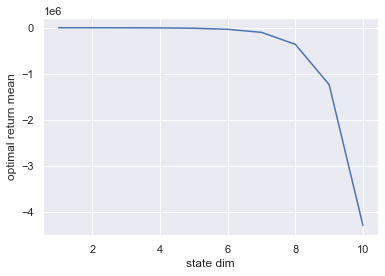

In [48]:
state_dims = np.arange(1, 11)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=True, samples=100)
).mean(-1)

x = "state dim"; y = "optimal return mean"
data={x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. control dimension

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

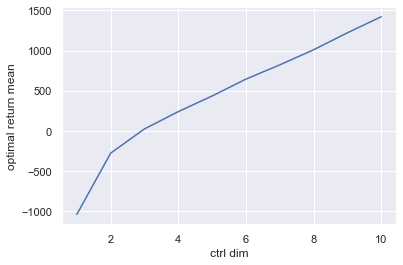

In [49]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.arange(1, 11)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=True, samples=100)
).mean(-1)

x = "ctrl dim"; y = "optimal return mean"
data = {x: ctrl_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. horizon length

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

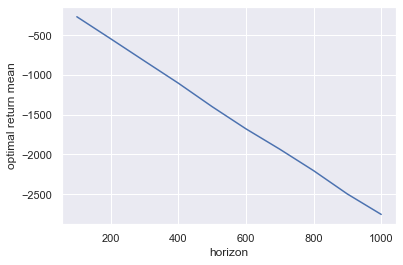

In [50]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = 100 * np.arange(1, 11)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=True, samples=100)
).mean(-1)

x = "horizon"; y = "optimal return mean"
data = {x: horizons, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Optimal expected return vs. state & control dimension

Computing performance by LQG dims:   0%|          | 0/20 [00:00<?, ?it/s]

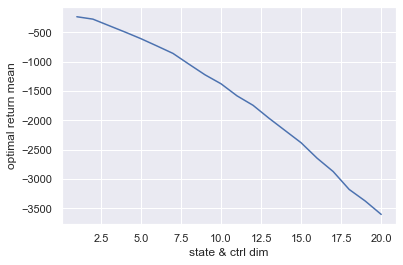

In [51]:
state_dims = ctrl_dims = np.arange(1, 21)
horizons = np.full(20, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=True, samples=100)
).mean(-1)

x = "state & ctrl dim"; y = "optimal return mean"
data = {x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Random expected return vs. state dimension

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

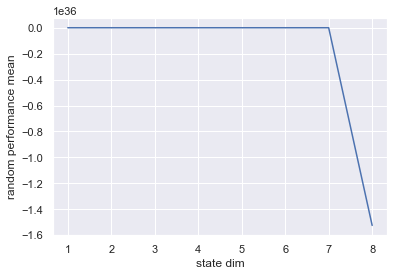

In [52]:
state_dims = np.arange(1, 11)
# state_dims = np.array([1, 2, 3, 4, 4, 4, 4, 4, 4, 4])
ctrl_dims = np.full(10, 2, dtype=int)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=False, samples=100)
).mean(-1)

x = "state dim"; y = "random performance mean"
data={x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Random expected return vs. control dimension

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

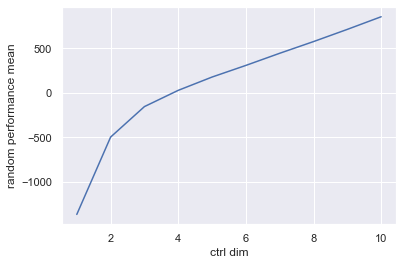

In [53]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.arange(1, 11)
horizons = np.full(10, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=False, samples=100)
).mean(-1)

x = "ctrl dim"; y = "random performance mean"
data = {x: ctrl_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Random expected return vs. horizon length

Computing performance by LQG dims:   0%|          | 0/10 [00:00<?, ?it/s]

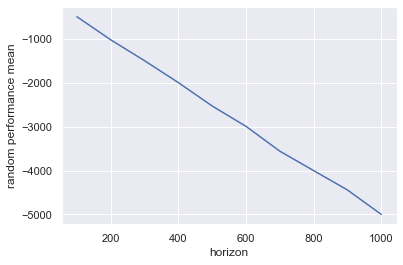

In [54]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = 100 * np.arange(1, 11)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=False, samples=100)
).mean(-1)

x = "horizon"; y = "random performance mean"
data = {x: horizons, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

#### Random expected return vs. state & control dimension

Computing performance by LQG dims:   0%|          | 0/20 [00:00<?, ?it/s]

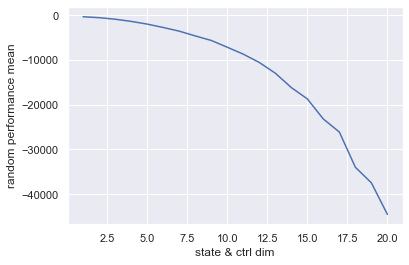

In [55]:
state_dims = ctrl_dims = np.arange(1, 21)
horizons = np.full(20, 100, dtype=int)
opt_ret_means = performance_matrix(
    state_dims, ctrl_dims, horizons, lambda s, c, h: performance_samples((s, c, h), optimal=False, samples=100)
).mean(-1)

x = "state & ctrl dim"; y = "random performance mean"
data = {x: state_dims, y: opt_ret_means}
ax = sns.lineplot(x=x, y=y, data=data)
plt.show()

---
## Multivariate analysis of cost scaling

### Checklist
- [x] Plot the average expected return against two variables, e.g., `n_state` and `n_ctrl`, as a 3D surface plot
- [ ] ~Use the insights gained from observing the cost scaling to propose a _downscaling_ parameter for random QuadCosts~
- [x] Use the analysis above to also derive a scale parameter for the random Gaussian noise for policy generation

In [56]:
def plot_3d_from_2d_function(ax, xrange: np.ndarray, yrange: np.ndarray, function: callable[[np.ndarray, np.ndarray], np.ndarray]):
    length = len(xrange)
    xbatch, ybatch = np.meshgrid(xrange, yrange)
    assert xbatch.shape == ybatch.shape == (length, length)

    x_arr, y_arr = map(lambda x: x.reshape((-1,)), (xbatch, ybatch))
    assert x_arr.shape == y_arr.shape == (length ** 2,), f"expected: {(length ** 2,)}; x_arr: {x_arr.shape}; y_arr {y_arr.shape}"

    z_arr = function(x_arr, y_arr)
    assert z_arr.shape == x_arr.shape, f"{z_arr.shape} != {x_arr.shape}"
    
    zbatch = z_arr.reshape(xbatch.shape)
    ax.plot_surface(xbatch, ybatch, zbatch, cmap=cm.coolwarm)    

### State vs. control dimension with fixed horizon

In what follows we set the horizon length to 100 steps.

<div class="alert alert-block alert-info">
    <b>Note:</b> we only plot values when control dimensions are at least as large as state dimensions (<code>n_ctrl >= n_state</code>). Having a state dimension much bigger than the control dimension induces very high <b>optimal</b> costs, causing plots to be difficult to read and potential numerical precision errors.
</div>

<div class="alert alert-block alert-warning">
    This might be due to the problem being underactuated
</div>

#### Best expected return

In [30]:
def performances_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon: int, optimal: bool) -> np.ndarray:
    horizon_arr = np.full_like(state_dim_arr, fill_value=horizon)
    exp_opt_ret_mat = performance_matrix(
        state_dim_arr, ctrl_dim_arr, horizon_arr, lambda s, c, h: performance_samples((s, c, h), optimal=optimal, samples=100, clip_ctrl_dim=True)
    )
    return exp_opt_ret_mat

In [31]:
def average_performance_by_state_ctrl_dim(state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, optimal: bool) -> np.ndarray:
    z_arr = performances_by_state_ctrl_dim(state_dim_arr, ctrl_dim_arr, horizon=100, optimal=optimal).mean(axis=-1) 
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

Computing performance by LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

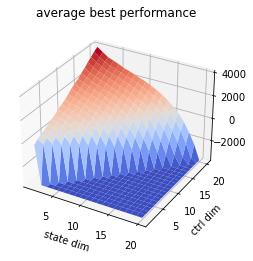

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=np.arange(1, 21),
    function=lambda x, y: average_performance_by_state_ctrl_dim(x, y, optimal=True),
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average best performance")
plt.show()

#### Expected return from random policy

Computing performance by LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

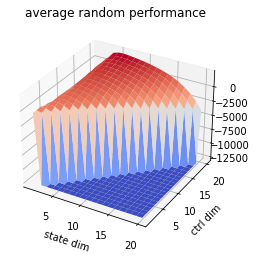

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=np.arange(1, 21),
    function=lambda x, y: average_performance_by_state_ctrl_dim(x, y, optimal=False),
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average random performance")
plt.show()

### State & control dimension vs. horizon length

#### Best expected return

In [32]:
def performances_by_horizon(state_ctrl_dim: np.ndarray, horizon_arr: np.ndarray, optimal: bool) -> np.ndarray:
    state_dim_arr = ctrl_dim_arr = state_ctrl_dim
    opt_perf_mat = performance_matrix(
        state_dim_arr, ctrl_dim_arr, horizon_arr, lambda s, c, h: performance_samples((s, c, h), optimal=optimal, samples=100)
    )
    return opt_perf_mat

In [33]:
def average_performance_by_horizon(state_ctrl_dim: np.ndarray, horizon_arr: np.ndarray, optimal: bool) -> np.ndarray:
    z_arr = performances_by_horizon(state_ctrl_dim, horizon_arr, optimal=optimal).mean(axis=-1)
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

Computing performance by LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

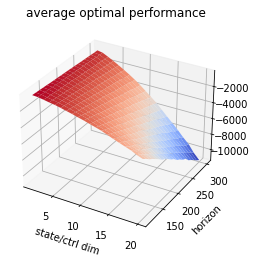

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=100 + 10 * np.arange(1, 21),
    function=lambda x, y: average_performance_by_horizon(x, y, optimal=True),
)
ax.set_xlabel("state/ctrl dim")
ax.set_ylabel("horizon")
ax.set_title("average optimal performance")
plt.show()

#### Random expected return

Computing performance by LQG dims:   0%|          | 0/400 [00:00<?, ?it/s]

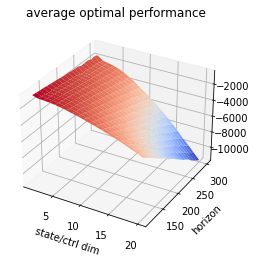

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax, 
    xrange=np.arange(1, 21),
    yrange=100 + 10 * np.arange(1, 21),
    function=lambda x, y: average_performance_by_horizon(x, y, optimal=False),
)
ax.set_xlabel("state/ctrl dim")
ax.set_ylabel("horizon")
ax.set_title("average optimal performance")
plt.show()